# **arxiv-evaluation**

Evaluating the quality of embeddings across increasingly specialized models.


## **Setup**

This notebook is designed to work in both Google Colab and local environments.

**For Google Colab:**
- **Mount Google Drive:** Enables saving files and accessing them across Colab.
    > ⚠ **Warning** <br>
    > This mounts your entire Google Drive, giving theoretical access to all files. While the code only accesses the project folder, consider using a dedicated Google account.
- **Clone the repository:** Ensures the latest code and utility modules are available.
- Add repo to Python path: Lets us import custom project modules as regular Python packages.

**For local environments:**
- Add project root to Python path: Lets us import custom project modules from the parent directory.

[ Optionally ]:
- Enable Autoreload: Lets us modify utility modules without having to reload them manually (useful for development).

In [1]:
import os
import sys

def setup_environment(repo_url, dev=False, drive_mount_path="/content/drive"):
    """Sets up the development environment for both Google Colab and local environments."""

    if "google.colab" not in sys.modules:
        # Define local project root
        project_root = os.path.dirname(os.getcwd())

        print("Not running in Google Colab.\nSkipping Colab setup.")

    else:
        # Mount Google Drive
        from google.colab import drive
        drive.mount(drive_mount_path, force_remount=True)

        # Define where within Drive to clone the git repository
        project_parent_dir = os.path.join(drive_mount_path, "MyDrive")
        project_name = repo_url.split("/")[-1].replace('.git', "")
        project_root = os.path.join(project_parent_dir, project_name)

        # Clone the repository if it doesn't exist
        if not os.path.exists(project_root):
            print(f"\nCloning repository into {project_root}")
            try:
                os.chdir(project_parent_dir)  # Change to the parent directory to clone the repo
                !git clone {repo_url}
            finally:
                os.chdir(project_root)  # Always change back to the original directory, even if clone fails
        else:
            print(f"\nRepository already exists at {project_root}")

        print("\nColab setup complete.")

    # Add project to Python path
    if project_root not in sys.path:
        sys.path.insert(0, project_root)
        print(f"\n'{project_root}' added to Python path.")
    else:
        print(f"\n'{project_root}' in Python path.")

    # Enable autoreload (for developement)
    if dev:
        from IPython import get_ipython
        ipython = get_ipython()

        # Load extension quietly if not already loaded
        if "autoreload" not in ipython.extension_manager.loaded:
            ipython.magic("load_ext autoreload")

        print("\nAutoreload extension enabled (mode 2).")
        ipython.magic("autoreload 2")

In [2]:
setup_environment("https://github.com/nadrajak/arxiv-semantic-search.git", dev=True)

Mounted at /content/drive

Repository already exists at /content/drive/MyDrive/arxiv-semantic-search

Colab setup complete.

'/content/drive/MyDrive/arxiv-semantic-search' added to Python path.

Autoreload extension enabled (mode 2).


## **Imports**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch

from sentence_transformers import SentenceTransformer
from sentence_transformers.evaluation import TripletEvaluator


# Custom modules
from utils import config
from utils import data_loader
from utils import preprocessing
from utils import triplet_dataset

In [4]:
# Initialize randomness
np.random.seed(config.RANDOM_SEED);
torch.manual_seed(config.RANDOM_SEED);

config.setup_plot_style()

## **Load data**


We use the [arXiv dataset from Kaggle](https://www.kaggle.com/Cornell-University/arxiv), which contains metadata and abstracts for scholarly papers across STEM fields.

Below, we load a sample of the dataset and briefly inspect its structure.

In [5]:
# Download dataset from Kaggle
arxiv_dataset_path = data_loader.load_arxiv_dataset()

In [6]:
# Load json file as a pandas DataFrame
eval_nrows = 1_000
data = pd.read_json(arxiv_dataset_path, lines=True, nrows=(config.FT_NROWS + eval_nrows))

# Skip first `config.FT_NROWS` because they were used for training
data = data.iloc[config.FT_NROWS:]

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 15000 to 15999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1000 non-null   float64
 1   submitter       1000 non-null   object 
 2   authors         1000 non-null   object 
 3   title           1000 non-null   object 
 4   comments        875 non-null    object 
 5   journal-ref     512 non-null    object 
 6   doi             646 non-null    object 
 7   report-no       80 non-null     object 
 8   categories      1000 non-null   object 
 9   license         77 non-null     object 
 10  abstract        1000 non-null   object 
 11  versions        1000 non-null   object 
 12  update_date     1000 non-null   object 
 13  authors_parsed  1000 non-null   object 
dtypes: float64(1), object(13)
memory usage: 109.5+ KB
None


## **Preprocessing**

In [7]:
# Select essential columns
data = data[["title", "abstract", "categories", "authors"]].copy()

# Apply light preprocessing to text columns
data = preprocessing.normalize_whitespace(data)
data = preprocessing.normalize_abstracts(data)

# Simplify categories
data = preprocessing.truncate_categories(data)

In [8]:
data.head()

,title,abstract,category,authors
15000,Nonlinear transport of Bose-Einstein condensat...,We study the coherent flow of interacting Bose...,cond-mat,"Tobias Paul, Michael Hartung, Klaus Richter, a..."
15001,On the geometry of the moduli space of spin cu...,We determine the smooth locus and the locus of...,math,Katharina Ludwig
15002,Rotational cooling efficiency upon molecular i...,The low-temperature (up to about 100K) collisi...,physics,"M. Wernli. E. Bodo, F.A. Gianturco"
15003,On the girth of random Cayley graphs,We prove that random d-regular Cayley graphs o...,math,"Alex Gamburd, Shlomo Hoory, Mehrdad Shahshahan..."
15004,A Conceptual Analysis of Mass Loss and Frequen...,To better understand Wolf-Rayet stars as proge...,astro-ph,A. J. Onifer and K. G. Gayley


## **Model evaluation**

We evaluate embeddings across a progression of increasingly specialized models to understand the impact of domain-specific pre-training on scientific text categorization:

- **GloVe**: Static word embeddings averaged to sentence level, representing pre-transformer approaches to text representation.<br>
[[Pennington et al., 2014](https://nlp.stanford.edu/pubs/glove.pdf)], [[Hugging Face](https://huggingface.co/sentence-transformers/average_word_embeddings_glove.6B.300d)].
- **BERT**: Transformer-based contextual embeddings trained on general English text, establishing the standard transformer baseline.<br>
[[Devlin et al., 2019](https://arxiv.org/abs/1810.04805)], [[Hugging Face](https://huggingface.co/bert-base-uncased)].
- **SciBERT**: BERT architecture retrained on scientific publications, isolating the effect of domain-specific pre-training.<br>
[[Beltagy et al., 2019](https://arxiv.org/abs/1903.10676)], [[Hugging Face](https://huggingface.co/allenai/scibert_scivocab_uncased)].
- **SPECTER**: SciBERT further trained on citation relationships to learn document-level semantic similarity in scientific literature.<br>
[[Cohan et al., 2020](https://arxiv.org/abs/2004.07180)], [[Hugging Face](https://huggingface.co/allenai/specter)].
- **SPECTER (fine-tuned)**: Our task-specific adaptation of SPECTER, optimized for the target classification task.

This progression allows us to measure the incremental benefit of domain adaptation (SciBERT vs BERT), document-level training (SPECTER vs SciBERT), and task-specific fine-tuning.

In [9]:
model_configs = [
    ("average_word_embeddings_glove.6B.300d", "GloVe"),
    ("google-bert/bert-base-uncased", "BERT"),
    ("allenai/scibert_scivocab_uncased", "SciBERT"),
    ("allenai-specter", "SPECTER"),
    ("nadrajak/allenai-specter-ft2", "SPECTER (fine-tuned)"),
]

In [10]:
# Load all models
model_names, model_pretty_names = zip(*model_configs)
models = [SentenceTransformer(name) for name in model_names]

### **Triplet accuracy**

In [11]:
anchors, positives, negatives = triplet_dataset.generate_triplets(data, n=len(data))

In [12]:
evaluator = TripletEvaluator(
    anchors=anchors,
    positives=positives,
    negatives=negatives,
    similarity_fn_names=["cosine", "euclidean", "dot"],
)

In [13]:
results = []
for model, model_name in zip(models, model_pretty_names):
    result = evaluator(model, output_path=None)
    result['model'] = model_name
    results.append(result)

results_df = pd.DataFrame(results).set_index('model').drop(columns=['max_accuracy'])

In [14]:
results_df.round(4).head()

,cosine_accuracy,euclidean_accuracy,dot_accuracy
model,,,
GloVe,0.6383,0.6311,0.5699
BERT,0.7264,0.7047,0.6933
SciBERT,0.7492,0.7409,0.6497
SPECTER,0.7896,0.7845,0.7979
SPECTER (fine-tuned),0.9275,0.9295,0.9306


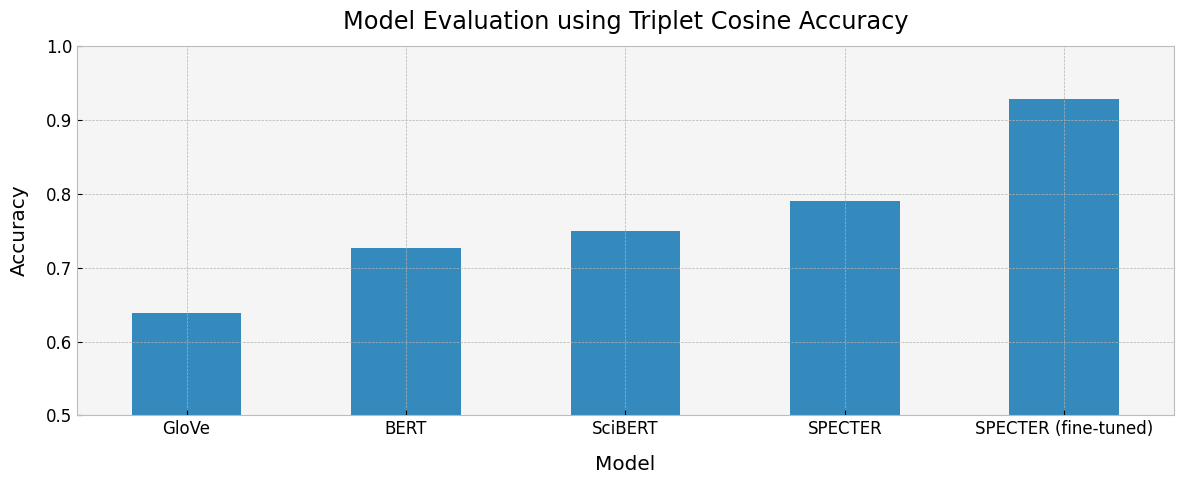

In [15]:
plt.figure(figsize=(12, 5))

results_df['cosine_accuracy'].plot(kind='bar')
plt.title('Model Evaluation using Triplet Cosine Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=0, ha='center')
plt.ylim([0.5, 1])

plt.tight_layout()

### **Metrics@k**

In [16]:
# TODO

### **Clustering**


In [17]:
# TODO

## **Conclusion**

In [18]:
# TODO